In [1]:
import pandas as pd
import numpy as np
import pathlib
import datetime
from datetime import datetime, timedelta, date
from rich import print
from collections import namedtuple
from dataclasses import dataclass, asdict
import operator
import tomllib
import tomlkit as tml
import json
import xarray as xr
from csvb.ingest import apply_rule, sel_factory, ApplyOp, SelectOp, AOP, SOP, Rule, to_transactions, strip_currency
import plotly.express as px
import plotly.graph_objects as go
#from decimal import Decimal, getcontext

#getcontext().prec = 2
pd.options.mode.copy_on_write = True

In [2]:
def accounts(trans):
    return set(trans["From"]).union(set(trans["To"]))

def read_and_apply(df, rulepth, debug=False):
    with open(rulepth) as f:
        for rule in tml.load(f)["rules"]:
            if debug:
                print(rule)
            apply_rule(Rule(**rule), df)
    return df
    

In [3]:
home = pathlib.Path.home()
cfgpth = home / ".config" / "csvb" / "config.toml"
with open(cfgpth, 'rb') as f:
    cfg = tomllib.load(f)
cfg

{'title': 'csvb config',
 'paths': {'path': 'als/csvbdata/',
  'bank': 'als/csvbdata/bank',
  'products': 'als/csvbdata/products/',
  'rules': 'als/csvbdata/rules/'}}

In [4]:
try:
    del apl
except NameError:
    pass
dfs = []
for fn in (home / pathlib.Path(cfg["paths"]["bank"])).glob("Apple Card Transactions*.csv"):
    dfs.append(pd.read_csv(fn, header=0, parse_dates=["Transaction Date", "Clearing Date"]))
apl = pd.concat(dfs)
apl = apl.rename(columns={"Amount (USD)": "Amount"})
apl["Amount"] = -1 * apl["Amount"]
apl["From"] = ""

apl = read_and_apply(apl, home / cfg["paths"]["rules"] / "aplrules.toml")
apl = apl.sort_values(["Transaction Date"])
#apl[apl["From"] == ""]
apl

,Transaction Date,Clearing Date,Description,Merchant,Category,Type,Amount,Purchased By,From
15,2021-12-31,2022-01-03,APPLE.COM/BILL ONE APPLE PARK WAY 866-712-7753...,Apple Services,Other,Purchase,-14.99,Keith Davis,Expenses:Subscriptions
16,2021-12-31,2022-01-02,"FANDANGO 12200 W. OLYMPIC BLVD., 8668575191 90...",Fandango,Entertainment,Purchase,-11.04,Keith Davis,Expenses:Entertainment
14,2022-01-01,2022-01-03,APPLE.COM/BILL ONE APPLE PARK WAY 866-712-7753...,Apple Services,Other,Purchase,-5.99,Keith Davis,Expenses:Subscriptions
13,2022-01-01,2022-01-03,CKO*PATREON* MEMBERSHI600 TOWNSEND 833-9728766...,Cko*Patreon* Membershi,Other,Purchase,-7.00,Keith Davis,Expenses:Entertainment
12,2022-01-01,2022-01-03,APPLE.COM/BILL ONE APPLE PARK 1111111111 95014...,Apple Services,Other,Purchase,-30.14,Keith Davis,Expenses:Subscriptions
...,...,...,...,...,...,...,...,...,...
1,2024-02-29,2024-02-29,ACH DEPOSIT INTERNET TRANSFER FROM ACCOUNT END...,Ach Deposit Internet Transfer From Account End...,Payment,Payment,2161.31,Keith Davis,Transfer
48,2024-02-29,2024-02-29,MONTHLY INSTALLMENTS (22 OF 24),Monthly Installments (22 Of 24),Installment,Installment,-8.29,Keith Davis,Liabilities:Apple:Installments
49,2024-02-29,2024-02-29,MONTHLY INSTALLMENTS (1 OF 12),Monthly Installments (1 Of 12),Installment,Installment,-114.08,Keith Davis,Liabilities:Apple:Installments
51,2024-02-29,2024-02-29,MONTHLY INSTALLMENTS (22 OF 24),Monthly Installments (22 Of 24),Installment,Installment,-54.12,Keith Davis,Liabilities:Apple:Installments


In [5]:
try:
    del fst
except NameError:
    pass

fst = pd.read_csv(home / pathlib.Path(cfg["paths"]["bank"]) / "Jan-2024_1st.csv",
                    header=3, parse_dates=["Date"])

fst_old = pd.read_csv(home / pathlib.Path(cfg["paths"]["bank"]) / "Sep22-2023_1st_Source.csv",
                    header=3, parse_dates=["Date"])

fst_older = pd.read_csv(home / pathlib.Path(cfg["paths"]["bank"]) / "Jan22-Sep22_1st_Source.csv",
                    header=3, parse_dates=["Date"])

fst = pd.concat([fst, fst_old, fst_older])

fst["Amount"] = np.nansum([fst["Amount Credit"],fst["Amount Debit"]], axis=0)
fst["From"] = ""

fst = read_and_apply(fst, home / cfg["paths"]["rules"] / "fstrules.toml")
fst[fst["From"] == ""]

,Transaction Number,Date,Description,Memo,Amount Debit,Amount Credit,Balance,Check Number,Fees,Amount,From


In [6]:
try:
    del ally
except NameError:
    pass

ally = pd.read_csv(home / pathlib.Path(cfg["paths"]["bank"]) / "Jan-2024_Ally.csv",
                    header=0, parse_dates=["Date"])

ally["From"] = ""
ally = ally.rename(columns=dict(zip(ally.columns, [c.strip() for c in ally.columns])))

ally = read_and_apply(ally, home / cfg["paths"]["rules"] / "allyrules.toml")
#ally

In [7]:
try:
    del ndfcu
except NameError:
    pass

ndfcu = pd.read_csv(home / pathlib.Path(cfg["paths"]["bank"]) / "Jan2022-March-2024_NDFCU_CC.csv",
                    header=0, names=["Date", "Note", "Description", "Amount", "Balance"],
                    parse_dates=["Date"])

ndfcu["From"] = ""
ndfcu["Amount"] = ndfcu["Amount"].apply(strip_currency).astype(float)
#ndfcu = ally.rename(columns=dict(zip(ally.columns, [c.strip() for c in ally.columns:
ndfcu = read_and_apply(ndfcu, home / cfg["paths"]["rules"] / "ndfcurules.toml")
print(len(ndfcu))
ndfcu[ndfcu["From"] == ""]

1009

,Date,Note,Description,Amount,Balance,From


In [8]:
bank_tables = {"Assets:1st Source:Checking": fst,
               "Liabilities:Apple:Credit Card": apl.rename(columns={"Transaction Date": "Date"}),
              "Assets:Ally:Savings": ally,
              "Liabilities:NDFCU:Credit Card": ndfcu}


trans = to_transactions(bank_tables)
trans.sort_values("Date")

,Date,Description,Amount,From,To
0,2021-12-31,MARTIN S SUPERMARKE . SOUTHBEND . IN 0000,-86.95,Expenses:Groceries,Liabilities:NDFCU:Credit Card
1,2021-12-31,PHILLIPS 66 - 0082 FIR . MISHAWAKA . IN 0000,-26.93,Expenses:Auto:Fuel,Liabilities:NDFCU:Credit Card
2,2021-12-31,APPLE.COM/BILL ONE APPLE PARK WAY 866-712-7753...,-14.99,Expenses:Subscriptions,Liabilities:Apple:Credit Card
3,2021-12-31,"FANDANGO 12200 W. OLYMPIC BLVD., 8668575191 90...",-11.04,Expenses:Entertainment,Liabilities:Apple:Credit Card
4,2022-01-01,CVS/PHARMACY #08642 . SOUTH BEND . IN 0000,-24.70,Expenses:Medical:Body,Liabilities:NDFCU:Credit Card
...,...,...,...,...,...
2278,2024-02-29,MONTHLY INSTALLMENTS (1 OF 12),-23.25,Liabilities:Apple:Installments,Liabilities:Apple:Credit Card
2277,2024-02-29,NaN,-19.33,Transfer,Liabilities:NDFCU:Credit Card
2276,2024-02-29,Netflix.com . 408-5403700 . CA 0000,-15.49,Expenses:Subscriptions,Liabilities:NDFCU:Credit Card
2279,2024-02-29,MONTHLY INSTALLMENTS (22 OF 24),-54.12,Liabilities:Apple:Installments,Liabilities:Apple:Credit Card


In [9]:
try:
    del bal_decl
except NameError:
    pass

bal_decl = pd.read_csv(home / pathlib.Path(cfg["paths"]["bank"]) / "balances.csv",
                  header=0,
                  parse_dates=["Date"])

#bal_decl["From"] = ""
#bal["Amount"] = bal["Amount"].apply(strip_currency).astype(float)
#ndfcu = ally.rename(columns=dict(zip(ally.columns, [c.strip() for c in ally.columns])))
#bal_decl = bal_decl.sort_values("Date")
#bal_decl
#jan_bal = bal_decl.loc[(bal_decl["Date"] >= pd.Timestamp(2023, 12, 31)) &
#                       (bal_decl["Date"] <= pd.Timestamp(2024, 1, 1))
#trans = pd.concat([trans, bal_decl])
bal_decl

,Date,Account,Statement Balance
0,2021-12-31,Liabilities:Apple:Credit Card,-2522.77
1,2021-12-31,Assets:1st Source:Checking,5067.54
2,2022-12-31,Liabilities:NDFCU:Credit Card,-76.69
3,2023-11-30,Liabilities:NDFCU:Credit Card,-2085.08
4,2023-10-31,Liabilities:NDFCU:Credit Card,-2492.89
5,2023-09-30,Liabilities:NDFCU:Credit Card,-1581.47
6,2023-08-31,Liabilities:NDFCU:Credit Card,-69.79
7,2023-07-31,Liabilities:NDFCU:Credit Card,-3172.26
8,2023-06-30,Liabilities:NDFCU:Credit Card,-1409.14
9,2023-05-31,Liabilities:NDFCU:Credit Card,-351.48


In [10]:
def create_ledgers(trans):
    """ Create a ledger for each account of all from / to transactions and create balance / time column.
    'Transaction Pair' is a terrible name, but it reminds that this is 1 half of a known transation for use
    as a ledger of an account and running balance calculation.
    All values appended from the "From" side of a transaction are reversed here, because a positive value
    "From" this account subtracts from it's balance.
    
    """
    # TODO: Add an option of a start of / end of period dates. Automatically calculate balance at
    # beginning of period.
    # TODO: Add processing of balance assertions to allow checks and reconciliation.
    
    fl = trans.groupby("From")
    tl = trans.groupby("To")
    ledgers = {}
    for acct in accounts(trans):
        # From accounts, note the negative applied to Amount.
        try:
            df = pd.DataFrame(trans.loc[fl.groups[acct], ["Date", "Description", "To"]]).rename(columns={"To": "Transaction Pair"})
            df["Incoming Amount"] = -1 * trans.loc[fl.groups[acct], "Amount"]
            ledgers[acct] = df
        # If account is not in From group, skip.
        except KeyError:
            pass

        # To accounts.

        try:
            df = pd.DataFrame(trans.loc[tl.groups[acct], ["Date", "Description", "From"]]).rename(columns={"From": "Transaction Pair"})
            df["Incoming Amount"] = trans.loc[tl.groups[acct], "Amount"]
            try:
                ledgers[acct] = pd.concat([ledgers[acct], df])
            # If account was not also in From accounts list, don't concat.
            except KeyError:
                ledgers[acct] = df
        # If account is not in list To accounts, skip.
        except KeyError:
            pass
            
        # Sort and apply cumulative sum.
        ledgers[acct] = ledgers[acct].sort_values("Date")
        ledgers[acct]["Balance"] = ledgers[acct]["Incoming Amount"].cumsum()

    return ledgers

def trans_to_ledger(trans, acct, bal_decl = None, clean=False, leq=True):
    """ Craete a single ledger. This is a step to using ledgers as a view on the transactions rather than
    a precalcualted object.
    
    """   
    fl = trans.groupby("From")
    tl = trans.groupby("To")
    #ledgers = {}
    #for acct in accounts(trans):
    # From accounts, note the negative applied to Amount.
    try:
        df = pd.DataFrame(trans.loc[fl.groups[acct], ["Date", "Description", "To"]]).rename(columns={"To": "Transaction Pair"})
        df["Incoming Amount"] = -1 * trans.loc[fl.groups[acct], "Amount"]
        ledger = df
        # If account is not in From group, skip.
    except KeyError:
        pass

    # To accounts.

    try:
        df = pd.DataFrame(trans.loc[tl.groups[acct], ["Date", "Description", "From"]]).rename(columns={"From": "Transaction Pair"})
        df["Incoming Amount"] = trans.loc[tl.groups[acct], "Amount"]
        try:
            ledger = pd.concat([ledger, df])
        # If account was not also in From accounts list, don't concat.
        except (NameError, UnboundLocalError):
            ledger = df
    # If account is not in list To accounts, skip.
    except KeyError:
        pass
    if clean:
        ledger = clean_ledger(ledger)        
    # Sort and apply cumulative sum.
    
    if bal_decl is not None:
        ledger = append_init_row(ledger, acct, bal_decl, leq=leq)
    ledger = ledger.sort_values("Date")
    ledger["Balance"] = ledger["Incoming Amount"].cumsum()

    return ledger

def clean_ledger(ledger):
    """Remove transactions occurring before the last transaction with all accounts assigned.
    Intended to catch incomplete data and return a useful ledger set on a per account basis.
    """
    #clean = {}
    #for acct in ledgers:
    try:
        clean = ledger.loc[[ledger["From"] == ""]:,:]
    except KeyError:
        clean = ledger
        
    return clean

def init_balance(bal_decl, acct, first_date, leq=False):
    #first_date = min(ledger["Date"])
    if leq:
        acct_balances = bal_decl.loc[(bal_decl["Account"] == acct) & (bal_decl["Date"] <= first_date)]
    else:
        acct_balances = bal_decl.loc[(bal_decl["Account"] == acct) & (bal_decl["Date"] < first_date)]
    
    # Catch indexerror if no balance found.
    try:
        return acct_balances.sort_values("Date").iloc[-1]
    except IndexError:
        return None

def append_init_row(ledger, acct, bal_decl, leq=False):
    #print(acct)
    #print(ledger)
    # Find proper initial balance.
    init = init_balance(bal_decl, acct, min(ledger["Date"]), leq=leq)

    # Skip if no appropriate balance was found.
    if init is not None:
        
        # Create df of initial balance row.
        decl_to_ledg_col = {"Statement Balance": "Incoming Amount", "Account": "Transaction Pair"}
        init_df = pd.DataFrame(init).T.rename(columns=decl_to_ledg_col)
        init_df["Description"] = "Initial Balance"

        # Add to first row, make sure we are sorted before recalculating balance column.
        ledger = pd.concat([init_df, ledger]).sort_values("Date")
        ledger["Balance"] = ledger["Incoming Amount"].cumsum()
    return ledger  
        

#ledgers = create_ledgers(trans)
ledgers = {}
for acct in accounts(trans):
    ledgers[acct] = trans_to_ledger(trans, acct, bal_decl=bal_decl, clean=True)

In [116]:
bals = []
firstds = []
lastds = []
initbals = []

for acct in ledgers:
    bals.append(ledgers[acct]["Incoming Amount"].sum())
    firstds.append(ledgers[acct]["Date"].iloc[0])
    lastds.append(ledgers[acct]["Date"].iloc[-1])
    initial = ledgers[acct].loc[ledgers[acct]["Description"] == "Initial Balance"]
    if len(initial) != 0:
        initbals.append(initial["Balance"].iloc[0])
    else:
        initbals.append(0)
    #initbals.append(ledgers[acct]["Balance"].iloc[0])
    
acct_bals = pd.DataFrame({"Period Start": firstds,
                          "Initial Balance": initbals,
                          "Period End": lastds,
                          "Ending Balance": bals},
                         index = ledgers.keys())
acct_bals.index.name = "Account String"

acct_tpls = []
for ix in acct_bals.index.str.split(":"):
    if len(ix) == 3:
        acct_tpls.append(ix)
    elif len(ix) == 2:
        acct_tpls.append((ix[0], ix[1], ""))
    elif len(ix) == 1:
        acct_tpls.append((ix[0],"", ""))

acct_bals.index = pd.MultiIndex.from_tuples(acct_tpls, names=["Type", "Account", "Subaccount"])
acct_bals

Period Start  Initial Balance Period End  \
Type        Account      Subaccount                                             
Expenses    Misc                       2022-01-13             0.00 2023-11-27   
            Pet          Care          2022-02-11             0.00 2023-12-19   
            Reimbursible               2022-10-17             0.00 2024-02-21   
            Auto                       2022-01-14             0.00 2022-01-14   
                         Insurance     2022-06-10             0.00 2023-12-27   
...                                           ...              ...        ...   
            Home         Maintenance   2022-04-05             0.00 2023-10-24   
            Gifts                      2022-09-28             0.00 2024-01-03   
Liabilities Apple        Credit Card   2021-12-31         -2522.77 2024-02-29   
Expenses    Personal                   2022-01-06             0.00 2024-02-10   
            Utilities                  2022-01-05             0.00 2024-02-19   

                                      Ending Balance  
Type        Account      Subaccount                   
Expenses    Misc                              136.12  
            Pet          Care                 810.00  
            Reimbursible                     2907.51  
            Auto                                9.62  
                         Insurance           2042.05  
...                                              ...  
            Home         Maintenance         4592.36  
            Gifts                             215.62  
Liabilities Apple        Credit Card          210.89  
Expenses    Personal                          895.13  
            Utilities                       12258.56  

[61 rows x 4 columns]

In [117]:
acct_bals["Difference"] = acct_bals["Ending Balance"] - acct_bals["Initial Balance"]

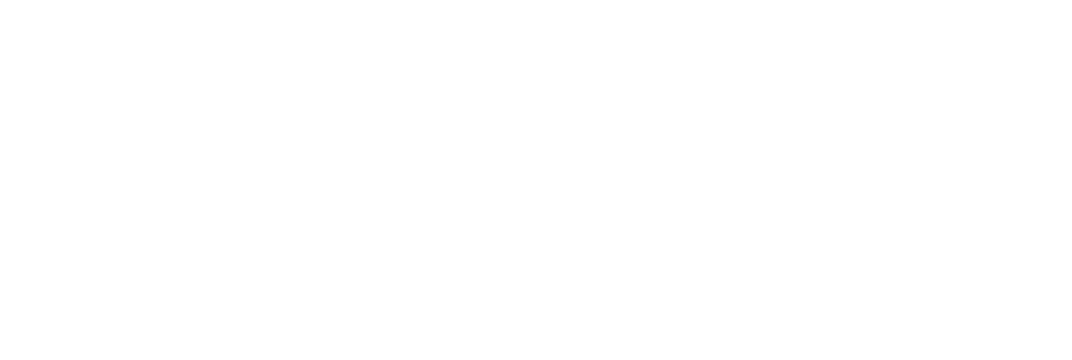

In [114]:
balfig = go.Figure(go.Sunburst(labels=acct_bals

In [14]:
#flow = trans.groupby(["From", "To"])
pt = trans.copy()
pt.loc[trans["Amount"] < 0, "To"] = trans.loc[trans["Amount"] < 0, "From"]
pt.loc[trans["Amount"] < 0, "From"] = trans.loc[trans["Amount"] < 0, "To"]
pt.loc[trans["Amount"] < 0, "Amount"] = -1 * trans.loc[trans["Amount"] < 0, "Amount"]
flow = pt.groupby(["From", "To"])

In [15]:
flow_df = pd.DataFrame(flow.Amount.aggregate("sum"))
flow_df

Amount
From                          To                                     
Assets:1st Source:Checking    Expenses:Auto:Insurance         2042.05
                              Expenses:Auto:Registration       260.35
                              Expenses:Cash                   1313.25
                              Expenses:Fitness:Equipment       100.00
                              Expenses:Fitness:ID             4725.00
...                                                               ...
Liabilities:NDFCU:Credit Card Transfer                         141.81
Transfer                      Assets:1st Source:Checking      9981.50
                              Assets:Ally:Savings             1200.00
                              Liabilities:Apple:Credit Card  52571.68
                              Liabilities:NDFCU:Credit Card  54210.82

[101 rows x 1 columns]

In [16]:
accts = list(accounts(flow_df.index.to_frame()))

labels = accts
sources = [accts.index(a) for a in flow_df.index.to_frame()["From"].values]
targets = [accts.index(a) for a in flow_df.index.to_frame()["To"].values]
values = flow_df["Amount"]

f = go.Figure(data=[go.Sankey(
    node = dict(
        pad=15,
        thickness = 5,
        line=dict(color = "black", width = 0.5),
        label = labels
    ),
    link = dict(
        source = sources,
        target = targets,
        value = values.values,
    )
)
                   ]
             )

labels

['Expenses:Auto:Insurance',
 'Expenses:Auto',
 'Expenses:Auto:Registration',
 'Income:Apple Cash',
 'Expenses:Groceries',
 'Expenses:Reimbursable',
 'Liabilities:NDFCU:Credit Card',
 'Expenses:Projects',
 'Expenses:Home:Mortgage',
 'Expenses:Clothing',
 'Expenses:Entertainment',
 'Expenses:AMAZON',
 'Expenses:Subscriptions',
 'Expenses:Restaurants',
 'Liabilities:Apple:Installments',
 'Income:Taxes',
 'Income:Interest',
 'Expenses:Cash',
 'Transfer:Auto:Loan',
 'Expenses:Home:Repair',
 'Expenses:Interest',
 'Expenses:Fitness:Recovery',
 'Expenses:Home Furnishings',
 'Transfer',
 'Expenses:Entertainment:Reading',
 'Expenses:Gifts',
 'Expenses:Misc',
 'Assets:Ally:Savings',
 'Expenses:Pet:Care',
 'Expenses:Reimbursible',
 'Expenses:Entertainment:Personal',
 'Expenses:Auto:Tolls',
 'Expenses:Fitness:Equipment',
 'Income:Notre Dame:Regular',
 'Expenses:Home:Repairs',
 'Expenses:Medical:Therapy',
 'Expenses:Auto:Maintenance',
 'Expenses:Electronics',
 'Expenses:Medical:Dentist',
 'Expenses:

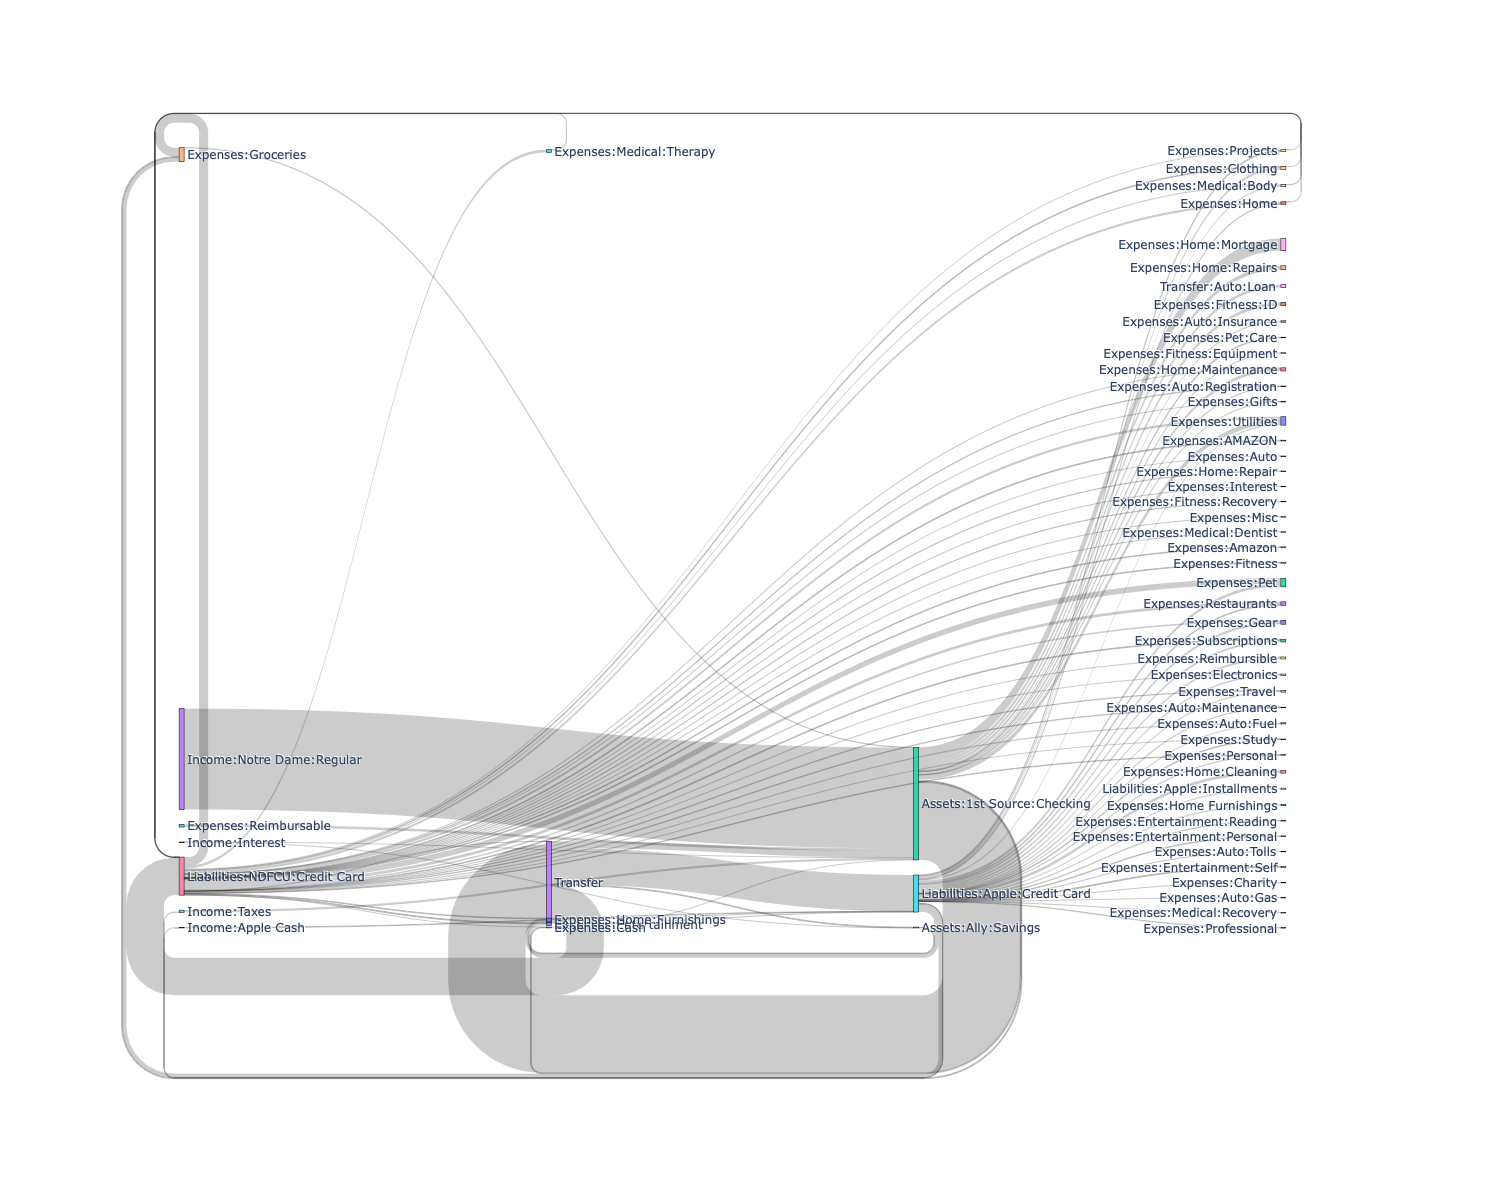

In [17]:
f.update_layout(height=1200)
f.show()

,Period Start,Initial Balance,Period End,Ending Balance,Difference,Account
Account,,,,,,
Expenses:Misc,2022-01-13,0.00,2023-11-27,136.12,136.12,Expenses
Expenses:Pet:Care,2022-02-11,0.00,2023-12-19,810.00,810.00,Expenses
Expenses:Reimbursible,2022-10-17,0.00,2024-02-21,2907.51,2907.51,Expenses
Expenses:Auto,2022-01-14,0.00,2022-01-14,9.62,9.62,Expenses
Expenses:Auto:Insurance,2022-06-10,0.00,2023-12-27,2042.05,2042.05,Expenses
...,...,...,...,...,...,...
Expenses:Home:Maintenance,2022-04-05,0.00,2023-10-24,4592.36,4592.36,Expenses
Expenses:Gifts,2022-09-28,0.00,2024-01-03,215.62,215.62,Expenses
Liabilities:Apple:Credit Card,2021-12-31,-2522.77,2024-02-29,210.89,2733.66,Liabilities


In [51]:
expenses = mi_bal.loc["Expenses"]

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [57]:
df = px.data.tips()

In [58]:
df

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2
